In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/acoustics_final.csv')
# drive link
# https://drive.google.com/file/d/1CHo0b5WE_-k2V7DN2NfU_RDFD99nGtCz/view?usp=share_link

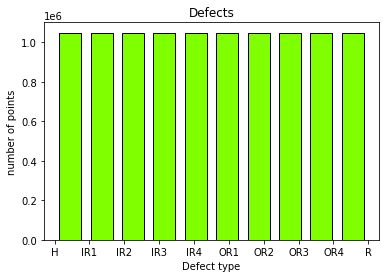

In [ ]:
plt.hist(df.DEFECT,edgecolor='black',color='chartreuse',rwidth=0.7)
plt.title('Defects')
plt.xlabel('Defect type')
plt.ylabel('number of points')
plt.show()


In [ ]:
df

,amp,DEFECT
0,-0.178953,H
1,-0.185128,H
2,-0.143508,H
3,-0.092996,H
4,-0.049894,H
...,...,...
10485745,-0.239221,R
10485746,-0.249225,R
10485747,-0.344073,R
10485748,-0.421632,R


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.loc[:,'amp'] = scaler.fit_transform(df.loc[:,'amp'].values.reshape(-1,1))

In [ ]:
df

,amp,DEFECT
0,-0.082869,H
1,-0.085611,H
2,-0.067135,H
3,-0.044711,H
4,-0.025577,H
...,...,...
10485745,-0.109624,R
10485746,-0.114065,R
10485747,-0.156171,R
10485748,-0.190602,R


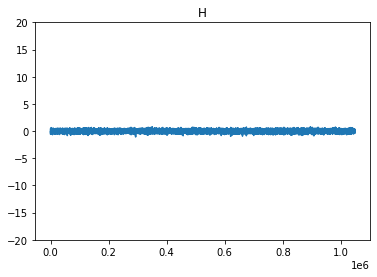

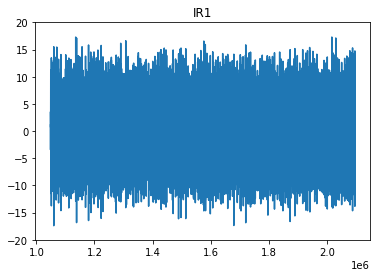

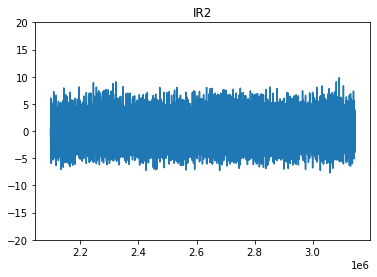

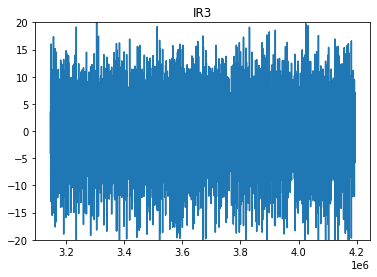

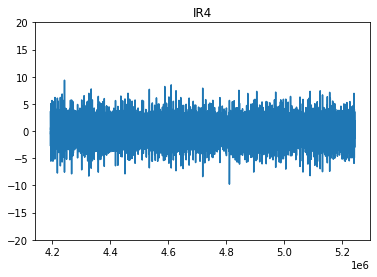

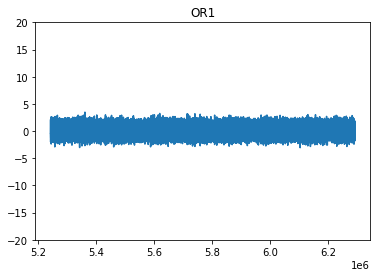

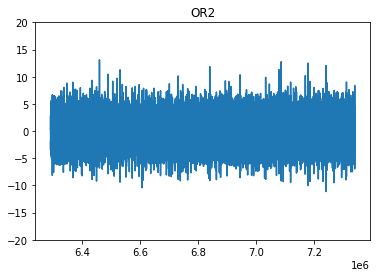

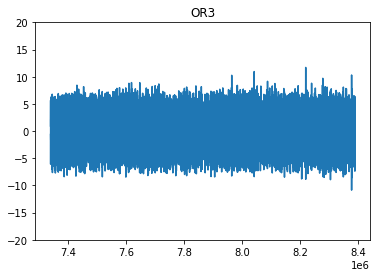

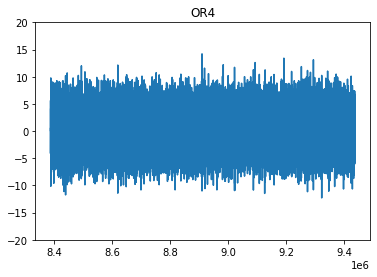

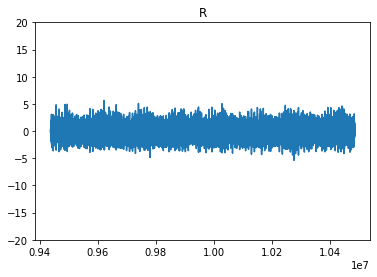

In [ ]:
import matplotlib.pyplot as plt
for f in df.DEFECT.unique():
  sdf = df[df['DEFECT']==f]
  plt.plot(sdf.amp)
  plt.title(f)
  plt.ylim(-20, 20)
  plt.show()

In [ ]:
random_seed = 42   
n_time_steps = 50 
n_features = 1 
step = 10 
n_classes = len(df.DEFECT.unique())
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

In [ ]:
from scipy import stats

In [ ]:
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):  

    xs = df['amp'].values[i: i + 50]
    label = stats.mode(df['DEFECT'][i: i + 50])[0][0]

    segments.append([xs])

    labels.append(label)

reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

#labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
labels_enc = encoder.fit_transform(np.array(labels).reshape(-1,1))

In [ ]:
labels_arr = labels_enc.toarray()

In [ ]:
labels_arr.shape

(1048570, 10)

In [ ]:
reshaped_segments.shape

(1048570, 50, 1)

In [ ]:
len(labels)

1048570

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels_arr, test_size = 0.2, random_state = random_seed)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 256, input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences=True))
# Dropout layer
model.add(Dropout(0.5)) 
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(units = 64, input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences=False))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='tanh'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 256)           264192    
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 128)           197120    
                                                                 
 lstm_6 (LSTM)               (None, 50, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 50, 32)            12416     
                                                                 
 lstm_8 (LSTM)               (None, 50, 32)            8320      
                                                                 
 lstm_9 (LSTM)               (None, 32)               

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [ ]:
callbacks = [ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=learning_rate),EarlyStopping(monitor="val_loss", patience=10, verbose=1)]


history = model.fit(X_train, y_train,callbacks=[callbacks], epochs = 100, validation_split = 0.2, batch_size = batch_size, verbose = 1)

Epoch 1/100
656/656 [==============================] - 71s 96ms/step - loss: 1.6255 - accuracy: 0.3685 - val_loss: 1.3189 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 2/100
656/656 [==============================] - 62s 94ms/step - loss: 1.1941 - accuracy: 0.5480 - val_loss: 1.1079 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 3/100
656/656 [==============================] - 62s 94ms/step - loss: 1.0652 - accuracy: 0.5974 - val_loss: 1.0319 - val_accuracy: 0.6084 - lr: 0.0010
Epoch 4/100
656/656 [==============================] - 61s 94ms/step - loss: 1.0042 - accuracy: 0.6216 - val_loss: 0.9885 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/100
656/656 [==============================] - 62s 94ms/step - loss: 0.9456 - accuracy: 0.6436 - val_loss: 0.8978 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 6/100
656/656 [==============================] - 61s 94ms/step - loss: 0.8787 - accuracy: 0.6697 - val_loss: 0.8400 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 7/100
656/656 [==============================]

In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

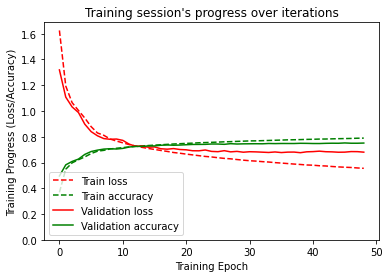

In [ ]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

205/205 [==============================] - 7s 33ms/step - loss: 0.6793 - accuracy: 0.7526
Test Accuracy : 0.752596378326416
Test Loss : 0.6793258190155029


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
y_test_preds = model.predict(X_test)


6554/6554 [==============================] - 63s 9ms/step


In [ ]:
y_test_pred = encoder.inverse_transform(y_test_preds)
y_test_act = encoder.inverse_transform(y_test)

In [ ]:
targets = encoder.categories_

In [ ]:
targets[0]

array(['H', 'IR1', 'IR2', 'IR3', 'IR4', 'OR1', 'OR2', 'OR3', 'OR4', 'R'],
      dtype='<U3')

In [ ]:
metrics_report = classification_report(y_test_act,y_test_pred,target_names=targets[0])

In [ ]:
print(metrics_report)

              precision    recall  f1-score   support

           H       0.68      0.85      0.75     20925
         IR1       0.81      0.80      0.80     21119
         IR2       0.71      0.67      0.69     20838
         IR3       0.78      0.84      0.81     21112
         IR4       0.67      0.64      0.65     20611
         OR1       0.95      0.94      0.95     21143
         OR2       0.84      0.75      0.79     21149
         OR3       0.75      0.74      0.75     20739
         OR4       0.76      0.77      0.76     21074
           R       0.59      0.51      0.55     21004

    accuracy                           0.75    209714
   macro avg       0.75      0.75      0.75    209714
weighted avg       0.75      0.75      0.75    209714



In [ ]:
from sklearn.metrics import confusion_matrix
def CMatrix(true_values,predicted_values,classes):
  cm = confusion_matrix(true_values,predicted_values)
  fig, ax = plt.subplots(figsize=(8,8))
  ax = sns.heatmap(cm,annot=True,fmt='d',cmap=sns.diverging_palette(220,20,n=7),
                   ax=ax)
  plt.ylabel('Actual labels')
  plt.xlabel('Predicted label')
  ax.set_xticklabels(classes)
  ax.set_yticklabels(classes)
  b, t = plt.ylim()
  b += 0.5
  t -= 0.5
  plt.ylim(b,t)
  plt.show()

In [ ]:
import seaborn as sns

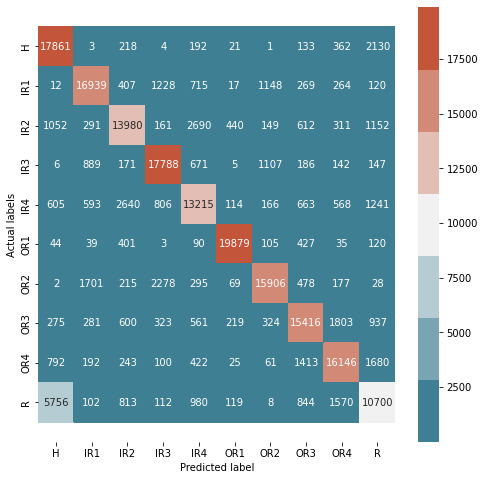

In [ ]:
CMatrix(y_test_act,y_test_pred,targets[0])

In [ ]:
import seaborn as sns
